In [1]:
#import

import numpy as np
import h5py
from copy import deepcopy
import os, zipfile, shutil,gzip
import pandas as pd
import glob
from scipy.stats import linregress
import os
from datetime import datetime
from datetime import timedelta
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import scipy
from numpy import polyfit, poly1d
from scipy import interpolate
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import time
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq
import math
import plotly
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import json
from scipy.interpolate import interp1d
from scipy.spatial.distance import euclidean
from scipy import interpolate

secret='TD.a-ZsKkoLFWpWQpFK.dejlvOF7NK0XBVM.LlD63gOWm7VaNIu.WzC3t3XtgjavrVM.PxZSkA5B3pBRC2T.baP4'
import nest_asyncio
nest_asyncio.apply()
from tardis_dev import datasets

if not sys.warnoptions:
    warnings.simplefilter("ignore")

D:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def download(ex,types,begin,end,coin):
    datasets.download(
            exchange=ex,
            data_types=[
                types
            ],
            from_date=begin,
            to_date=end,
            symbols=[coin],
            api_key=secret,
        )

In [35]:
def get_trade(begin, end, ex, coin):
    dt = []
    for file in os.listdir(f'C:/Users/杜威/Desktop/datasets'):
        date = file[(len(ex) + 8):(len(ex) + 18)]
        if date >= begin and date <= end:
            df = pd.read_csv(f'C:/Users/杜威/Desktop/datasets/{ex}_trades_{date}_{coin}.csv.gz')
            dt.append(df)
    dt = pd.concat(dt)
    f = lambda x: datetime.fromtimestamp(x / 1000000)
    dt['time'] = dt['timestamp'].map(f)
    return dt

In [4]:
def mean_price(df, group):
    df['time_group'] = df['time'].dt.floor(group)
    df['value'] = df['amount'] * df['price']
    dt = df[['time_group', 'side', 'amount', 'value']].groupby(['time_group', 'side'], as_index = False).sum()
    dt['price'] = dt['value'] / dt['amount']
    return dt

In [47]:
def plot_price_value(df, group, coin):
    dt = mean_price(df, group)
    df_b = dt[dt['side'] == 'buy']
    df_s = dt[dt['side'] == 'sell']
    fig = plt.figure(figsize = (15, 15))
    sub_fig1 = fig.add_subplot(311)
    sub_fig1.grid(True)
    plt.plot(df_b['time_group'], df_b['price'], label = 'buy price')
    plt.plot(df_s['time_group'], df_s['price'], label = 'sell price')
    plt.title('Price')
    plt.legend()

    sub_fig2 = fig.add_subplot(312)
    sub_fig2.grid(True)
    plt.plot(df_b['time_group'], df_b['value'], label = 'buy value')
    plt.plot(df_s['time_group'], df_s['value'], label = 'sell value')
    plt.title('Dallor Value')
    plt.legend()
    
    sub_fig3 = fig.add_subplot(313)
    sub_fig3.grid(True)
    dt1 = pd.merge(df_b, df_s[['time_group', 'price', 'value']], on = 'time_group')
    dt1['rate'] = dt1['price_x'] / dt1['price_y'] - 1
    plt.plot(dt1['time_group'], dt1['rate'], label = 'profit rate')
    plt.title('Rate')
    plt.legend()
    dt1.rename(columns = 
               {'price_x': 'price_buy', 'price_y': 'price_sell', 'value_x': 'value_buy', 'value_y': 'value_sell'}, inplace = True)
    dt1 = dt1[['time_group', 'price_buy', 'price_sell', 'value_buy', 'value_sell', 'rate']]
    dt1.to_csv(f'C:/Users/杜威/Desktop/tardis/backtesting/{coin}.csv')
    plt.savefig(f'C:/Users/杜威/Desktop/tardis/backtesting/{coin}.jpg')
    return dt1

In [70]:
def get_self_df(begin, end, group):
    df = []
    for ex in ['formal', 'test']:
        df_ = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/profit/plot/pos_fp/kraken_{ex}.csv', index_col=0)
        df_['time'] = df_['time'].astype('datetime64[ms]')
        df.append(df_)
    df = pd.concat(df).sort_values('time')
    df = df[df['time'] >= begin][df['time'] <= end]
    df['coin'] = df['coin1'] + df['coin2']
    df['value'] = abs(df['ch2']) * df['fp2']
    df['amount'] = abs(df['ch2'])
    df['profit'] = df['margin']
    df['time_group'] = df['time'].dt.floor(group)
    dt = df[['time_group', 'profit', 'amount', 'value', 'coin']].groupby(['time_group', 'coin'], as_index = False).sum()
    dt['fp'] = dt['value'] / dt['amount']
    return dt

In [58]:
def compara_allself(group, coin, all_df, self_df):
    recite = lambda x: x.replace('Z', '').replace('XETH', 'ETH').replace('XXBT', 'XBT').replace('XBT', 'BTC').replace('XXRP','XRP').replace('XLTC','LTC').replace('XXDG','XDG').lower().replace('-', '')
    self_df = self_df[self_df['coin'] == recite(coin)]
    
    dt = mean_price(all_df, group)
    df_b = dt[dt['side'] == 'buy']
    df_s = dt[dt['side'] == 'sell']
    dt1 = pd.merge(df_b, df_s[['time_group', 'price', 'value']], on = 'time_group')
    dt1['rate'] = dt1['price_x'] / dt1['price_y'] - 1
    dt1.rename(columns = 
               {'price_x': 'price_buy', 'price_y': 'price_sell', 'value_x': 'value_buy', 'value_y': 'value_sell'}, inplace = True)
    dt1['value_all'] = dt1.apply(lambda x:min(x['value_buy'], x['value_sell']), axis = 1)
    dt1 = dt1[['time_group', 'value_all', 'rate']]
    
    df = pd.merge(dt1, self_df, on = 'time_group')
    df['value_all'] *= df['fp']
    df['profit_all'] = df['value_all'] * df['rate']
    df = df[['time_group', 'value_all', 'profit_all', 'profit', 'value']]
    return df

In [44]:
ex = 'kraken'
coin = 'XBT-USD'
begin = '2023-04-03'
end = '2024-01-03'
group = '30min'

In [71]:
download(ex, 'trades', begin, end, coin)
#all_df = get_trade(begin, end, ex, coin)
self_df = get_self_df(begin, end, group)
df = compara_allself(group, coin, all_df, self_df)
#dt1 = plot_price_value(dt, coin)

In [ ]:
df = compara_allself(group, coin, all_df, self_df)

Text(0.5, 1.0, 'XBT-USD')

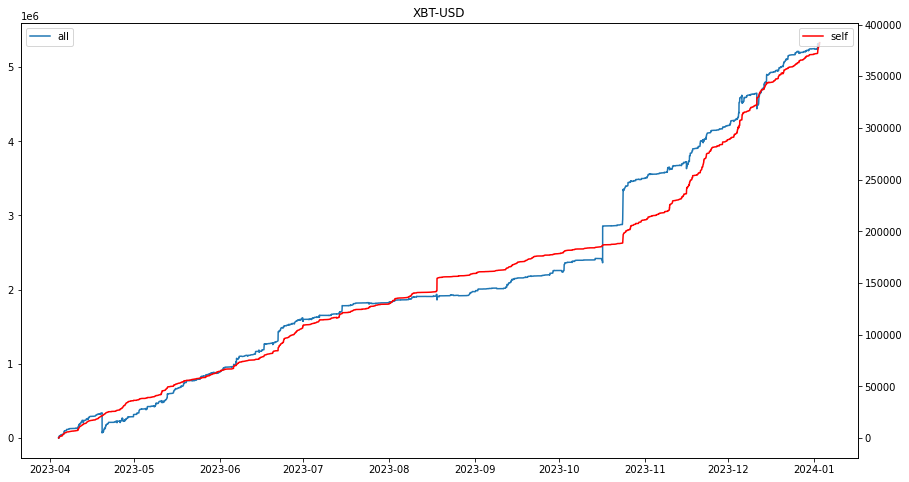

In [84]:
fig, ax1 = plt.subplots(figsize = (15, 8 ))
ax1.plot(df['time_group'], df['profit_all'].cumsum(), label = 'all')
plt.legend()
ax2 = ax1.twinx()  
ax2.plot(df['time_group'], df['profit'].cumsum(), label = 'self', color = 'red')
plt.legend(loc = 'upper right')
plt.title(coin)